In [2]:
import os
import numpy as np
import shutil
import pandas as pd
from PIL import Image
import torch
import pyiqa
from torch_fidelity import calculate_metrics
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# Paths and SNR levels

gt_path = '/home/ubuntu/dataset/Image_dataset/Kodak/'  # Ground truth path
method = "SD_Latent"  # Example method name
test_path = f'outputs/{method}'  # Noisy image path
snr_list = [0]
results_file = 'evaluation_results.csv'
BCR = 96  
# Metrics to calculate
metrics_list = ['psnr', 'ms_ssim', 'lpips', 'lpips-vgg', 'pieapp', 'dists', 'fid', 'kid']


def read_image(image_path):
    """Read an image from a file path and convert to a numpy array."""
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        return np.array(img)

def calculate_metric(recon_dir, gt_dir, metric_name):
    scores = []
    
    if metric_name == 'fid':
        temp_gt_dir = './temp/gt'
        if os.path.exists(temp_gt_dir):
            shutil.rmtree(temp_gt_dir)
        os.makedirs(temp_gt_dir)
        
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])[:len(recon_files)]
        for file in gt_files:
            shutil.copyfile(os.path.join(gt_dir, file), os.path.join(temp_gt_dir, file))
        
        fid_metrics = calculate_metrics(
            cuda=True,
            input1=recon_dir,
            input2=temp_gt_dir,
            fid=True,
            batch_size=1,
        )
        return fid_metrics['frechet_inception_distance']
    
    elif metric_name == 'kid':
        temp_gt_dir = './temp/gt'
        if os.path.exists(temp_gt_dir):
            shutil.rmtree(temp_gt_dir)
        os.makedirs(temp_gt_dir)
        
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])[:len(recon_files)]
        for file in gt_files:
            shutil.copyfile(os.path.join(gt_dir, file), os.path.join(temp_gt_dir, file))
        
        kid_metrics = calculate_metrics(
            cuda=True,
            input1=recon_dir,
            input2=temp_gt_dir,
            kid=True,
            batch_size=1,
            kid_subset_size=24
        )
        return kid_metrics['kernel_inception_distance_mean']
    
    else:
        metric = pyiqa.create_metric(metric_name)
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])
        for recon_file in recon_files:
            recon_path = os.path.join(recon_dir, recon_file)
            gt_path = os.path.join(gt_dir, recon_file)
            if os.path.exists(recon_path) and os.path.exists(gt_path):
                if metric_name in ['clipiqa', 'niqe', 'topiq_nr-face']:
                    score = metric(recon_path)
                else:
                    score = metric(recon_path, gt_path)
                scores.append(score.item())
        return np.mean(scores) if scores else None

# Initialize DataFrame
columns = ['Method', 'SNR', 'Bandwidth_Ratio'] + metrics_list
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=columns)
else:
    results_df = pd.read_csv(results_file)

# Calculate metrics
for snr in snr_list:
    recon_dir = os.path.join(test_path, f"{snr}dB")
    snr_results = {'Method': method, 'Bandwidth_Ratio': BCR, 'SNR': snr}
    
    for metric_name in metrics_list:
        score = calculate_metric(recon_dir, gt_path, metric_name)
        snr_results[metric_name] = score
        print(f"Method: {method}, Bandwidth_Ratio: {BCR}, SNR: {snr}, Metric: {metric_name}, Score: {score}")
    
    # Check for an existing row and update it
    condition = (results_df['Method'] == method) & (results_df['Bandwidth_Ratio'] == BCR) & (results_df['SNR'] == snr)
    if condition.any():
        results_df.loc[condition, metrics_list] = [snr_results[metric] for metric in metrics_list]
    else:
        results_df = pd.concat([results_df, pd.DataFrame([snr_results])], ignore_index=True)

# Save results to CSV
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}")


/home/ubuntu/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ubuntu/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-04-17 11:06:31.103545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for 

Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: psnr, Score: 13.457501808802286
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: ms_ssim, Score: 0.3052037587711718
Loading pretrained model LPIPS from /home/ubuntu/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: lpips, Score: 0.7733884478608767
Loading pretrained model LPIPS from /home/ubuntu/.cache/torch/hub/checkpoints/LPIPS_v0.1_vgg-a78928a0.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: lpips-vgg, Score: 0.6663918197154999
Loading pretrained model PieAPP from /home/ubuntu/.cache/torch/hub/checkpoints/PieAPPv0.1-0937b014.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: pieapp, Score: 3.702392299969991
Loading pretrained model DISTS from /home/ubuntu/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: dists, Score: 0.40643828362226486


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "outputs/SD_Latent/0dB" with extensions png,jpg,jpeg
Found 24 samples
/home/ubuntu/anaconda3/lib/python3.11/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "./temp/gt" with extensions png,jpg,jpeg
Found 24 samples
Processing samples                                                      
Frechet Inception Distance: 397.1716212039

Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: fid, Score: 397.1716212039472


Extracting features from input1
Looking for samples non-recursivelty in "outputs/SD_Latent/0dB" with extensions png,jpg,jpeg
Found 24 samples
Processing samples                                                      
Extracting features from input2
Looking for samples non-recursivelty in "./temp/gt" with extensions png,jpg,jpeg
Found 24 samples
Processing samples                                                      
                                                                       

Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 0, Metric: kid, Score: 0.19154696929857892
Results saved to evaluation_results.csv


Kernel Inception Distance: 0.19154696929857892 ± 6.06498209971441e-08


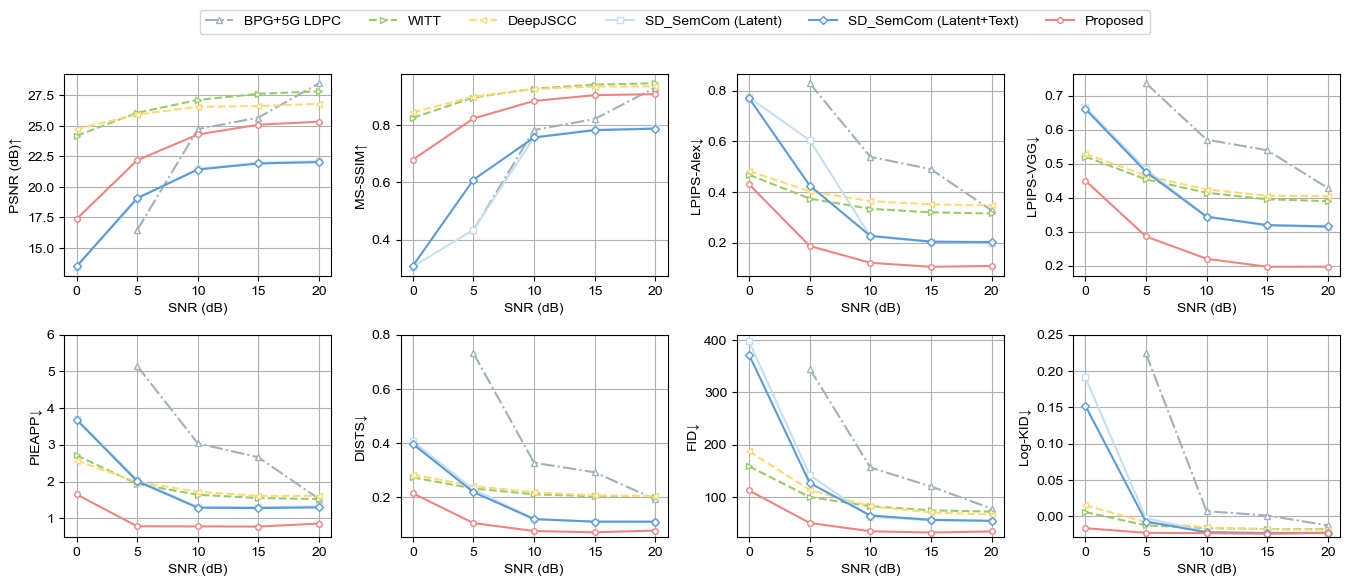

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
results_file = 'evaluation_results.csv'
# plt 字体
plt.rcParams['font.sans-serif'] = ['Arial']
def query_data(method=None, snr=None, bandwidth_ratio=None, metric=None):
    """
    根据给定条件查询 CSV 数据。
    支持当 snr 为列表时使用 in 语句查询。
    """
    df = pd.read_csv(results_file)
    query_conditions = []
    
    if method is not None:
        query_conditions.append(f"Method == '{method}'")
    if snr is not None:
        # 如果 snr 为列表，则使用 in 操作符
        if isinstance(snr, list):
            query_conditions.append("SNR in @snr")
        else:
            query_conditions.append(f"SNR == {snr}")
    if bandwidth_ratio is not None:
        query_conditions.append(f"Bandwidth_Ratio == {bandwidth_ratio}")
    
    query_str = ' & '.join(query_conditions)
    result = df.query(query_str)
    
    if metric is not None:
        result = result[['Method', 'SNR', 'Bandwidth_Ratio', metric]]
    
    return result
def plot_results(methods, snr_values, bandwidth_ratio, metrics, y_names, method_properties=None):
    """
    绘制各指标曲线图
    """
    # 默认的线型和标记符号
    default_line_styles = ['-', '--', '-.', ':']
    default_markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']

    num_metrics = len(metrics)
    cols = 4  # 每行图像的列数，可根据需要调整
    rows = math.ceil(num_metrics / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(3.4 * cols, 2.8 * rows), squeeze=False)
    axes = axes.flatten()

    for i, metric_name in enumerate(metrics):
        ax = axes[i]
        for j, method in enumerate(methods):
            # 根据 method_properties 获取自定义显示名称、颜色、线型、标记和对应的 SNR 范围
            if method_properties is not None:
                display_name = method_properties.get(method, {}).get('name', method)
                method_snr_values = method_properties.get(method, {}).get('snr_range', snr_values)
                color = method_properties.get(method, {}).get('color', f'C{j}')  # 默认颜色
                linestyle = method_properties.get(method, {}).get('linestyle', default_line_styles[j % len(default_line_styles)])
                marker = method_properties.get(method, {}).get('marker', default_markers[j % len(default_markers)])
            else:
                display_name = method
                method_snr_values = snr_values
                color = f'C{j}'  # 默认颜色
                linestyle = default_line_styles[j % len(default_line_styles)]
                marker = default_markers[j % len(default_markers)]
            
            metric_values = []
            for snr in method_snr_values:
                res = query_data(method=method, snr=snr, bandwidth_ratio=bandwidth_ratio, metric=metric_name)
                if not res.empty:
                    # 假设查询结果中只有一个匹配数据
                    metric_value = res[metric_name].iloc[0]
                else:
                    metric_value = None
                metric_values.append(metric_value)
            
            # 动态分配线型、标记和颜色
            ax.plot(
                method_snr_values, metric_values,
                linestyle=linestyle,  # 使用自定义线型
                marker=marker,        # 使用自定义标记
                color=color,          # 使用自定义颜色
                markersize=4,
                linewidth=1.5,
                markerfacecolor='w',
                markeredgewidth=1,
                label=display_name
            )
        
        ax.set_xlabel('SNR (dB)')
        ax.set_ylabel(y_names.get(metric_name, metric_name))
        ax.grid(True)
        if metric_name == 'kid':  # 检查当前指标是否为 KID
            ax.set_ylim(-0.028, 0.25)  # 设置 y 轴范围为 [0, 0.1]
        if metric_name == 'pieapp':
            ax.set_ylim(0.5, 6)
        if metric_name == 'dists':
            ax.set_ylim(0.055, 0.8)
        if metric_name == 'fid':
            ax.set_ylim(25, 410)
    
    # 隐藏多余的子图
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # 添加全局图例
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(methods))
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以给图例留出空间
    plt.savefig('metrics_plot.pdf', bbox_inches='tight')
    plt.show()

# === 示例：设置方法、指标和自定义属性 ===

methods = ['BPG_LDPC','WITT', 'DeepJSCC',  'SD_Latent','language_SemCom', 'proposed']
bandwidth_ratio = 96
metrics = ['psnr', 'ms_ssim', 'lpips', 'lpips-vgg', 'pieapp', 'dists', 'fid', 'kid']
y_names = {
    'psnr': 'PSNR (dB)↑',
    'ms_ssim': 'MS-SSIM↑',
    'lpips': 'LPIPS-Alex↓',
    'lpips-vgg': 'LPIPS-VGG↓',
    'pieapp': 'PIEAPP↓',
    'dists': 'DISTS↓',
    'fid': 'FID↓',
    'kid': 'Log-KID↓',
}
# 全局默认的 SNR 值
snr_values = [0, 5, 10, 15, 20]

# 定义各方法的自定义属性：显示名称、颜色、线型、标记和对应的 SNR 范围
method_properties = {
    'proposed': {'name': 'Proposed', 'snr_range': [0, 5, 10, 15, 20], 'color': '#ed8580', 'linestyle': '-', 'marker': 'o'},
    'DeepJSCC': {'name': 'DeepJSCC', 'snr_range': [0, 5, 10, 15, 20], 'color': '#fed976', 'linestyle': '--', 'marker': '<'},
    'WITT': {'name': 'WITT', 'snr_range': [0, 5, 10, 15, 20], 'color': '#99CC66', 'linestyle': '--', 'marker': '>'},
    'BPG_LDPC': {'name': 'BPG+5G LDPC', 'snr_range': [5, 10, 15, 20], 'color': '#A0B1BA', 'linestyle': '-.', 'marker': '^'},
    'VAE': {'name': 'VAE', 'snr_range': [0, 5, 10, 15, 20], 'color': '#9467bd', 'linestyle': ':', 'marker': 'v'},
    'language_SemCom': {'name': 'SD_SemCom (Latent+Text)', 'snr_range': [0, 5, 10, 15, 20], 'color': '#5B9BD5', 'linestyle': '-', 'marker': 'D'},
    'SD_Latent': {'name': 'SD_SemCom (Latent)', 'snr_range': [0, 5, 10, 15, 20], 'color': '#C5E1EF', 'linestyle': '-', 'marker': 's'},
}

plot_results(methods, snr_values, bandwidth_ratio, metrics, y_names, method_properties=method_properties)
# save pdf



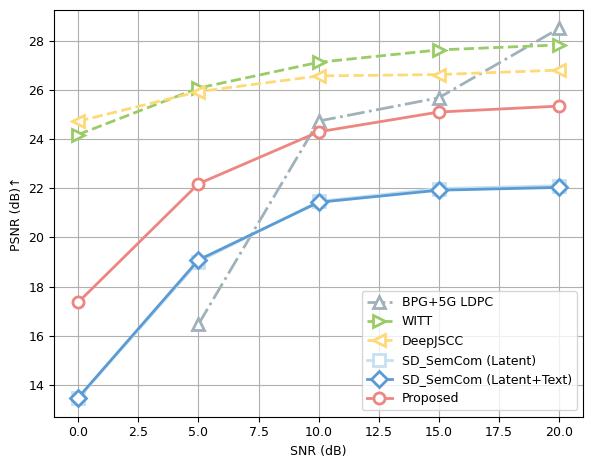

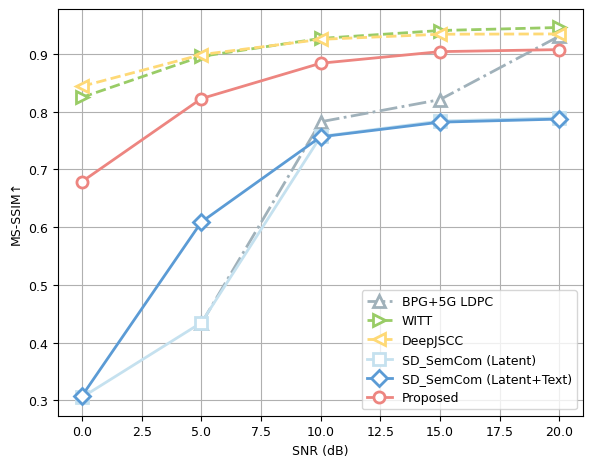

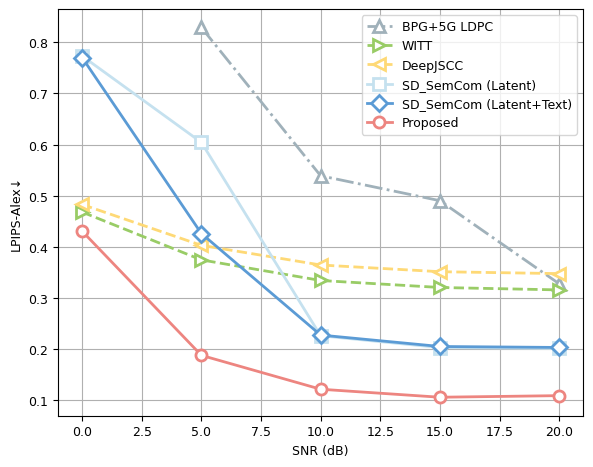

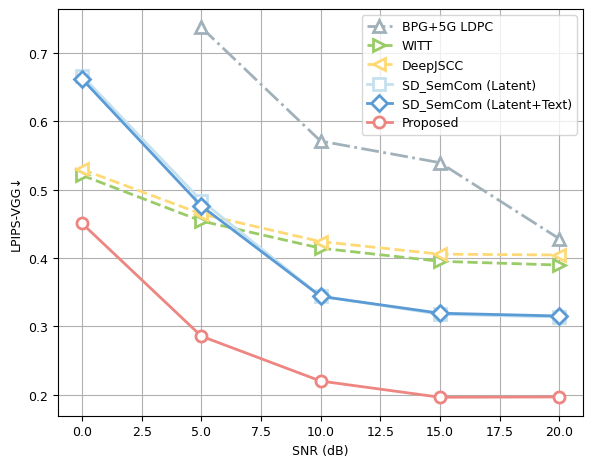

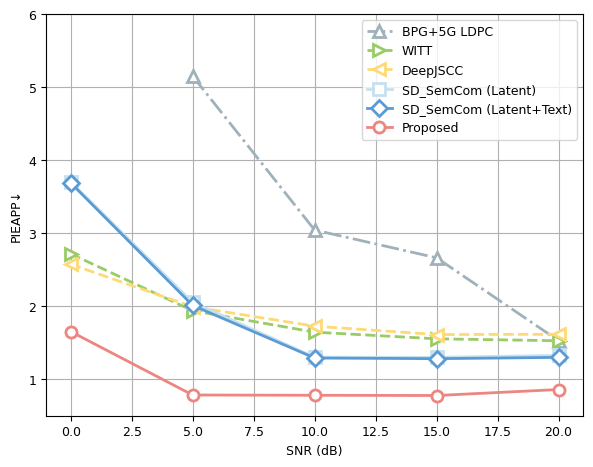

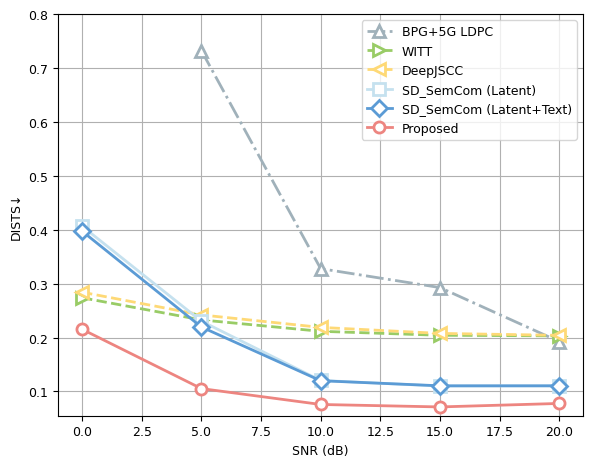

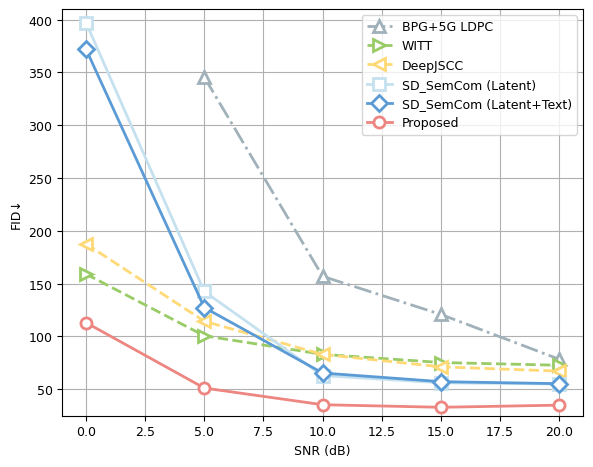

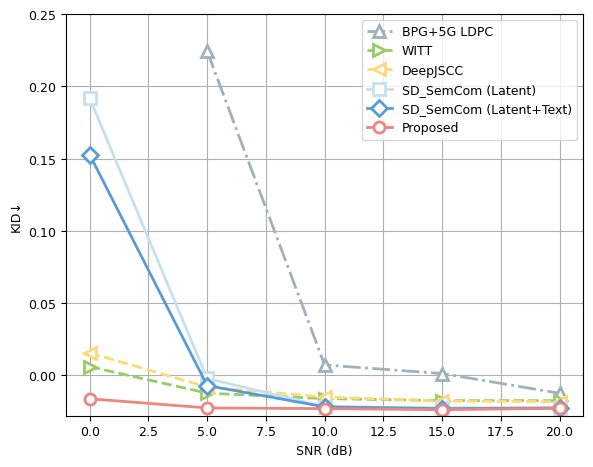

In [ ]:
import math
import matplotlib.pyplot as plt
import pandas as pd

results_file = 'evaluation_results.csv'
# 设置全局字体大小
plt.rcParams.update({'font.size': 9})
def query_data(method=None, snr=None, bandwidth_ratio=None, metric=None):
    """
    根据给定条件查询 CSV 数据。
    支持当 snr 为列表时使用 in 语句查询。
    """
    df = pd.read_csv(results_file)
    query_conditions = []
    
    if method is not None:
        query_conditions.append(f"Method == '{method}'")
    if snr is not None:
        # 如果 snr 为列表，则使用 in 操作符
        if isinstance(snr, list):
            query_conditions.append("SNR in @snr")
        else:
            query_conditions.append(f"SNR == {snr}")
    if bandwidth_ratio is not None:
        query_conditions.append(f"Bandwidth_Ratio == {bandwidth_ratio}")
    
    query_str = ' & '.join(query_conditions)
    result = df.query(query_str)
    
    if metric is not None:
        result = result[['Method', 'SNR', 'Bandwidth_Ratio', metric]]
    
    return result

def plot_results(methods, snr_values, bandwidth_ratio, metrics, y_names, method_properties=None):
    """
    绘制各指标曲线图
    """
    # 默认的线型和标记符号
    default_line_styles = ['-', '--', '-.', ':']
    default_markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']

    for i, metric_name in enumerate(metrics):
        fig, ax = plt.subplots(figsize=(6, 5))
        
        for j, method in enumerate(methods):
            # 根据 method_properties 获取自定义显示名称、颜色、线型、标记和对应的 SNR 范围
            if method_properties is not None:
                display_name = method_properties.get(method, {}).get('name', method)
                method_snr_values = method_properties.get(method, {}).get('snr_range', snr_values)
                color = method_properties.get(method, {}).get('color', f'C{j}')  # 默认颜色
                linestyle = method_properties.get(method, {}).get('linestyle', default_line_styles[j % len(default_line_styles)])
                marker = method_properties.get(method, {}).get('marker', default_markers[j % len(default_markers)])
            else:
                display_name = method
                method_snr_values = snr_values
                color = f'C{j}'  # 默认颜色
                linestyle = default_line_styles[j % len(default_line_styles)]
                marker = default_markers[j % len(default_markers)]
            
            metric_values = []
            for snr in method_snr_values:
                res = query_data(method=method, snr=snr, bandwidth_ratio=bandwidth_ratio, metric=metric_name)
                if not res.empty:
                    # 假设查询结果中只有一个匹配数据
                    metric_value = res[metric_name].iloc[0]
                else:
                    metric_value = None
                metric_values.append(metric_value)
            
            # 动态分配线型、标记和颜色
            ax.plot(
                method_snr_values, metric_values,
                linestyle=linestyle,  # 使用自定义线型
                marker=marker,        # 使用自定义标记
                color=color,          # 使用自定义颜色
                markersize=8,         # 增大标记大小
                linewidth=2,          # 增大线宽
                markerfacecolor='w',
                markeredgewidth=2,
                label=display_name
            )
        
        ax.set_xlabel('SNR (dB)')
        ax.set_ylabel(y_names.get(metric_name, metric_name))
        ax.grid(True)
        if metric_name == 'kid':  # 检查当前指标是否为 KID
            ax.set_ylim(-0.028, 0.25)  # 设置 y 轴范围为 [0, 0.1]
        if metric_name == 'pieapp':
            ax.set_ylim(0.5, 6)
        if metric_name == 'dists':
            ax.set_ylim(0.055, 0.8)
        if metric_name == 'fid':
            ax.set_ylim(25, 410)
        
        # 添加图例
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='best', frameon=True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # 调整布局以给图例留出空间
        plt.show()

# === 示例：设置方法、指标和自定义属性 ===

methods = ['BPG_LDPC','WITT', 'DeepJSCC', 'proposed']
bandwidth_ratio = 96
metrics = ['psnr', 'ms_ssim', 'lpips', 'lpips-vgg', 'pieapp', 'dists', 'fid', 'kid']
y_names = {
    'psnr': 'PSNR (dB)↑',
    'ms_ssim': 'MS-SSIM↑',
    'lpips': 'LPIPS-Alex↓',
    'lpips-vgg': 'LPIPS-VGG↓',
    'pieapp': 'PIEAPP↓',
    'dists': 'DISTS↓',
    'fid': 'FID↓',
    'kid': 'KID↓',
}
# 全局默认的 SNR 值
snr_values = [0, 5, 10, 15, 20]

# 定义各方法的自定义属性：显示名称、颜色、线型、标记和对应的 SNR 范围
method_properties = {
    'proposed': {'name': 'Proposed', 'snr_range': [0, 5, 10, 15, 20], 'color': '#ed8580', 'linestyle': '-', 'marker': 'o'},
    'DeepJSCC': {'name': 'DeepJSCC', 'snr_range': [0, 5, 10, 15, 20], 'color': '#fed976', 'linestyle': '--', 'marker': '<'},
    'WITT': {'name': 'WITT', 'snr_range': [0, 5, 10, 15, 20], 'color': '#99CC66', 'linestyle': '--', 'marker': '>'},
    'BPG_LDPC': {'name': 'BPG+5G LDPC', 'snr_range': [5, 10, 15, 20], 'color': '#A0B1BA', 'linestyle': '-.', 'marker': '^'},
    'VAE': {'name': 'VAE', 'snr_range': [0, 5, 10, 15, 20], 'color': '#9467bd', 'linestyle': ':', 'marker': 'v'},
    'language_SemCom': {'name': 'SD_SemCom (Latent+Text)', 'snr_range': [0, 5, 10, 15, 20], 'color': '#5B9BD5', 'linestyle': '-', 'marker': 'D'},
    'SD_Latent': {'name': 'SD_SemCom (Latent)', 'snr_range': [0, 5, 10, 15, 20], 'color': '#C5E1EF', 'linestyle': '-', 'marker': 's'},
}

plot_results(methods, snr_values, bandwidth_ratio, metrics, y_names, method_properties=method_properties)

In [5]:
import os
import numpy as np
import shutil
import pandas as pd
from PIL import Image
import torch
import pyiqa
from torch_fidelity import calculate_metrics
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
# Paths and SNR levels

gt_path = '/home/ubuntu/dataset/Image_dataset/Kodak/'  # Ground truth path
method = "SD_Latent"  # Example method name
test_path = f'outputs/{method}/ablation/T1_10_T3_10'  # Noisy image path
snr_list = [5]
results_file = 'ablation_results.csv'
BCR = 96  
# Metrics to calculate
metrics_list = ['psnr', 'ms_ssim', 'lpips', 'lpips-vgg', 'pieapp', 'dists', 'fid', 'kid']


def read_image(image_path):
    """Read an image from a file path and convert to a numpy array."""
    with Image.open(image_path) as img:
        img = img.convert('RGB')
        return np.array(img)

def calculate_metric(recon_dir, gt_dir, metric_name):
    scores = []
    
    if metric_name == 'fid':
        temp_gt_dir = './temp/gt'
        if os.path.exists(temp_gt_dir):
            shutil.rmtree(temp_gt_dir)
        os.makedirs(temp_gt_dir)
        
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])[:len(recon_files)]
        for file in gt_files:
            shutil.copyfile(os.path.join(gt_dir, file), os.path.join(temp_gt_dir, file))
        
        fid_metrics = calculate_metrics(
            cuda=True,
            input1=recon_dir,
            input2=temp_gt_dir,
            fid=True,
            batch_size=1,
        )
        return fid_metrics['frechet_inception_distance']
    
    elif metric_name == 'kid':
        temp_gt_dir = './temp/gt'
        if os.path.exists(temp_gt_dir):
            shutil.rmtree(temp_gt_dir)
        os.makedirs(temp_gt_dir)
        
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])[:len(recon_files)]
        for file in gt_files:
            shutil.copyfile(os.path.join(gt_dir, file), os.path.join(temp_gt_dir, file))
        
        kid_metrics = calculate_metrics(
            cuda=True,
            input1=recon_dir,
            input2=temp_gt_dir,
            kid=True,
            batch_size=1,
            kid_subset_size=24
        )
        return kid_metrics['kernel_inception_distance_mean']
    
    else:
        metric = pyiqa.create_metric(metric_name)
        recon_files = sorted([f for f in os.listdir(recon_dir) if f.endswith('.png')])
        gt_files = sorted([f for f in os.listdir(gt_dir) if f.endswith('.png')])
        for recon_file in recon_files:
            recon_path = os.path.join(recon_dir, recon_file)
            gt_path = os.path.join(gt_dir, recon_file)
            if os.path.exists(recon_path) and os.path.exists(gt_path):
                if metric_name in ['clipiqa', 'niqe', 'topiq_nr-face']:
                    score = metric(recon_path)
                else:
                    score = metric(recon_path, gt_path)
                scores.append(score.item())
        return np.mean(scores) if scores else None

# Initialize DataFrame
columns = ['Method', 'SNR', 'Bandwidth_Ratio'] + metrics_list
if not os.path.exists(results_file):
    results_df = pd.DataFrame(columns=columns)
else:
    results_df = pd.read_csv(results_file)

# Calculate metrics
for snr in snr_list:
    recon_dir = os.path.join(test_path, f"{snr}dB")
    snr_results = {'Method': method, 'Bandwidth_Ratio': BCR, 'SNR': snr}
    
    for metric_name in metrics_list:
        score = calculate_metric(recon_dir, gt_path, metric_name)
        snr_results[metric_name] = score
        print(f"Method: {method}, Bandwidth_Ratio: {BCR}, SNR: {snr}, Metric: {metric_name}, Score: {score}")
    
    # Check for an existing row and update it
    condition = (results_df['Method'] == method) & (results_df['Bandwidth_Ratio'] == BCR) & (results_df['SNR'] == snr)
    if condition.any():
        results_df.loc[condition, metrics_list] = [snr_results[metric] for metric in metrics_list]
    else:
        results_df = pd.concat([results_df, pd.DataFrame([snr_results])], ignore_index=True)

# Save results to CSV
results_df.to_csv(results_file, index=False)
print(f"Results saved to {results_file}")


Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: psnr, Score: 19.022172729174297
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: ms_ssim, Score: 0.6041656917409234
Loading pretrained model LPIPS from /home/ubuntu/.cache/torch/hub/checkpoints/LPIPS_v0.1_alex-df73285e.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: lpips, Score: 0.43433378264307976
Loading pretrained model LPIPS from /home/ubuntu/.cache/torch/hub/checkpoints/LPIPS_v0.1_vgg-a78928a0.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: lpips-vgg, Score: 0.4837556481361389
Loading pretrained model PieAPP from /home/ubuntu/.cache/torch/hub/checkpoints/PieAPPv0.1-0937b014.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: pieapp, Score: 2.052931919693947
Loading pretrained model DISTS from /home/ubuntu/.cache/torch/hub/checkpoints/DISTS_weights-f5e65c96.pth
Method: SD_Latent, Bandwidth_Ratio: 96, SNR: 5, Metric: dists, Score: 0.23039068281650543


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting statistics from input 1
Looking for samples non-recursivelty in "outputs/SD_Latent/ablation/T1_10_T3_10/5dB" with extensions png,jpg,jpeg
Found 24 samples
Processing samples                                                      
Extracting statistics from input 2
Looking for samples non-recursivelty in "./temp/gt" with extensions png,jpg,jpeg
Found 24 samples
Processing samples                                                      


KeyboardInterrupt: 

In [19]:
import torch
from torch import nn
from torchvision import transforms
from diffusers import StableDiffusionPipeline
from PIL import Image
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
import glob
from tqdm import tqdm


# 加载 runwayml/stable-diffusion-v1-5 的 pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
)
pipe = pipe.to("cuda")  # 放到GPU加速

# 预处理 transform
preprocess = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),  # [0,1]
])

# 读取 ./kodak_images/ 下所有图片
image_files = glob.glob("./kodak_images/*.png") + glob.glob("./kodak_images/*.jpg") + glob.glob("./kodak_images/*.jpeg")

latent_vectors = []

# 编码所有图片
power=0
for image_path in tqdm(image_files, desc="Encoding images"):
    image = Image.open(image_path).convert("RGB")
    image = preprocess(image).cuda()

    # 需要加 batch 维度
    image = image.unsqueeze(0)  # (1,3,512,512)
    
    # VAE编码
    latent = pipe.vae.encode(image * 2 - 1)  # 先把[0,1]范围拉到[-1,1]
    x = 0.18215 * latent.latent_dist.sample()  # 采样 + 缩放
    pipe.scheduler.set_timesteps(50)
    timesteps = pipe.scheduler.timesteps
    noise = torch.randn_like(latents)
    
    # 修正：确保T1步数与50步的调度器正确对齐
    # 在50步的调度器中，第T1步对应的索引
    T1=1
    t1_idx = int((T1 / 50) * len(timesteps))
    t1_idx = min(max(0, t1_idx), len(timesteps) - 1)  # 确保索引在有效范围内
    t1_timestep = timesteps[-t1_idx]
    noisy_latents = pipe.scheduler.add_noise(
        latents,
        noise,
        t1_timestep
    )
        
        # 更新 latents
    x = noisy_latents
    power+= torch.mean(torch.abs(x)**2, dim=tuple(range(1, x.dim())), keepdim=True)
print(power/24)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Encoding images: 100%|██████████| 24/24 [00:02<00:00, 10.56it/s]

tensor([[[[0.9440]]]], device='cuda:0', grad_fn=<DivBackward0>)


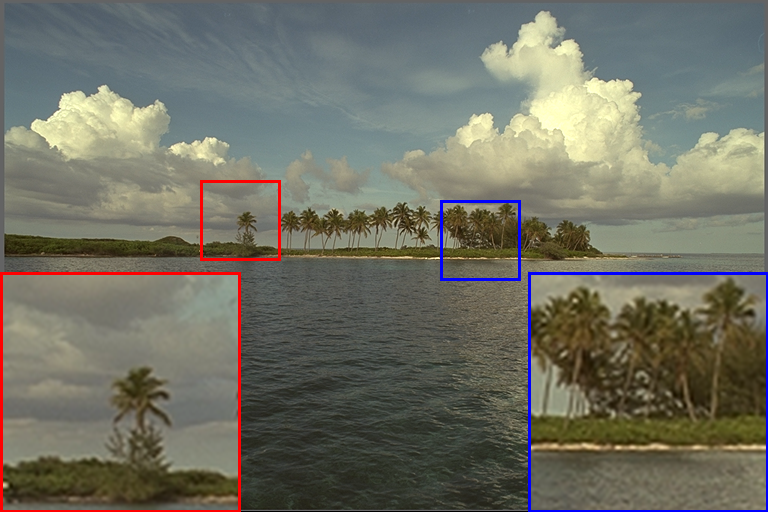

In [44]:
from PIL import Image, ImageDraw
from IPython.display import display  # Jupyter中显示图片

# 读取图片
SNR=5
methods=['DeepJSCC', 'WITT', 'SD_Text_Latent', 'BPG_LDPC', 'proposed', 'gt']
idx="16"
methods=['gt']
for method in methods:
    if method == 'gt':
        img_path = f"kodak_images/kodim{idx}.png"
    elif method =='WITT':
        img_path = f"outputs/{method}/{SNR}dB/recon_{idx}.png"
    else:
        img_path = f"outputs/{method}/{SNR}dB/kodim{idx}.png"

    img = Image.open(img_path)
    img_w, img_h = img.size

    # ✅ 第一区域：红色，左下角显示
    left1, upper1 = 200, 180
    width1, height1 = 80, 80
    right1 = min(left1 + width1, img_w)
    lower1 = min(upper1 + height1, img_h)

    region1 = img.crop((left1, upper1, right1, lower1))
    zoom_factor = 3
    region1_zoomed = region1.resize(
        (region1.width * zoom_factor, region1.height * zoom_factor),
        Image.Resampling.LANCZOS
    )

    # ✅ 第二区域：蓝色，右下角显示
    left2, upper2 = 440, 200
    width2, height2 = 80, 80
    right2 = min(left2 + width2, img_w)
    lower2 = min(upper2 + height2, img_h)

    region2 = img.crop((left2, upper2, right2, lower2))
    region2_zoomed = region2.resize(
        (region2.width * zoom_factor, region2.height * zoom_factor),
        Image.Resampling.LANCZOS
    )

    # 创建新图，与原图同尺寸
    combined_img = img.copy()

    # 粘贴放大图1到左下角
    paste1_x, paste1_y = 0, img_h - region1_zoomed.height
    combined_img.paste(region1_zoomed, (paste1_x, paste1_y))

    # 粘贴放大图2到右下角
    paste2_x = img_w - region2_zoomed.width
    paste2_y = img_h - region2_zoomed.height
    combined_img.paste(region2_zoomed, (paste2_x, paste2_y))

    # 绘制红色、蓝色边框
    draw = ImageDraw.Draw(combined_img)

    # 原图红框 + 放大图红框
    draw.rectangle([left1, upper1, right1, lower1], outline="red", width=3)
    draw.rectangle([paste1_x, paste1_y,
                    paste1_x + region1_zoomed.width,
                    paste1_y + region1_zoomed.height], outline="red", width=3)

    # 原图蓝框 + 放大图蓝框
    draw.rectangle([left2, upper2, right2, lower2], outline="blue", width=3)
    draw.rectangle([paste2_x, paste2_y,
                    paste2_x + region2_zoomed.width,
                    paste2_y + region2_zoomed.height], outline="blue", width=3)

    # 显示结果（Jupyter中）
    display(combined_img)

    # 保存结果
    combined_img.save(f"outputs/Compare/{method}_{SNR}dB_{idx}.png")

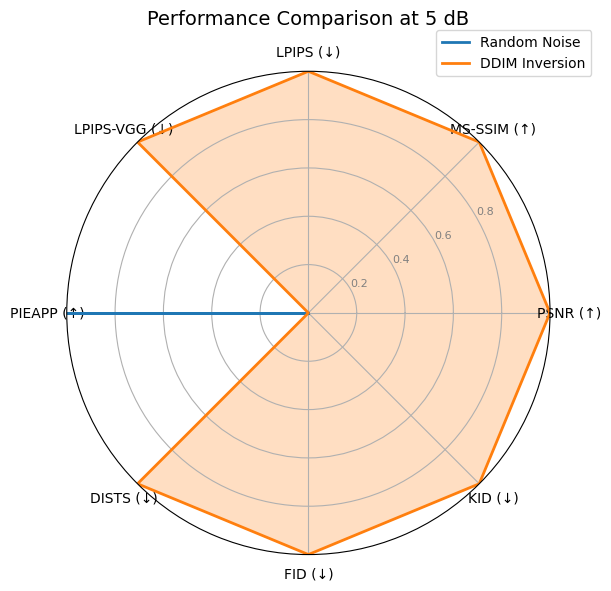